# Application of Markov Chain Monte Carlo (MCMC) for Parameter Estimation in Bayesian Statistic

### Pratical demonstration of Markov Chain Monte Carlo (MCMC) for Parameter Estimation in Bayesian Statistics for the CNM coursework in SINP during Fall 2022 by Arunava Mukherjee (17 October 2022, class 7)


#### 
 *  This program is free software; you can redistribute it and/or modify
 *  it under the terms of the GNU General Public License as published by
 *  the Free Software Foundation; either version 2 of the License, or
 *  (at your option) any later version.
 *
 *  This program is distributed in the hope that it will be useful,
 *  but WITHOUT ANY WARRANTY; without even the implied warranty of
 *  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 *  GNU General Public License for more details.
 *
 *  You should have received a copy of the GNU General Public License
 *  along with with program; see the file COPYING. If not, write to the
 *  Free Software Foundation, Inc., 59 Temple Place, Suite 330, Boston,
 *  MA  02111-1307  USA.

**(c) Arunava Mukherjee, 2022**

#### Acknowledgement: This code is adopted from this webpage: <http://mattpitkin.github.io/samplers-demo/pages/pyjags/>. 

In [1]:
from __future__ import print_function, division

import os
import sys
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.use("Agg") # force Matplotlib backend to Agg

import pyjags

### Setup a model and data 

#### define the model function (a linear model in this case)

In [2]:
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """
    
    return m * x + c

#### set the true values of the model parameters for creating the data

In [3]:
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 50
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# create the data - the model plus Gaussian noise
sigma = 2.0  # standard deviation of the noise
data = straight_line(x, m, c) + np.random.normal(scale=sigma, size=M)
y_true_model = straight_line(x, m, c)

#### plot the data

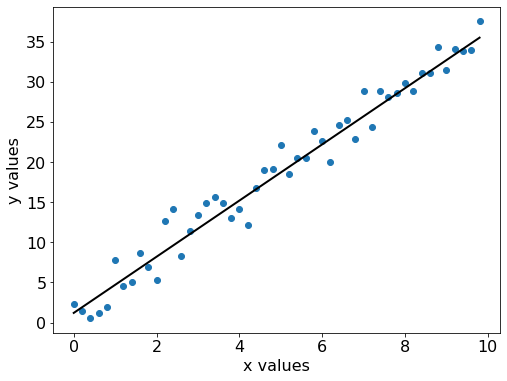

In [4]:
plt.figure(figsize = [8, 6])
plt.rcParams['font.size'] = '16'

plt.plot(x, data, 'o')
plt.plot(x, y_true_model, 'k-', lw=2)
plt.xlabel('x values')
plt.ylabel('y values')
#x.shape, data.shape

plt.show()

### Example of running PyJAGS to fit the parameters of a straight line

#### Create model code

In [5]:
line_code_jags = '''
model {{
    for (i in 1:N) {{
        y[i] ~ dnorm(c + m * x[i], {invvar}) # Gaussian likelihood
    }}
    m ~ dnorm({mmu}, {minvvar})     # Gaussian prior on m
    c ~ dunif({clower}, {cupper})   # Uniform prior on c
}}
'''

datadict = {'x': x,    # abscissa points (converted from numpy array to a list)
            'N': M,    # number of data points
            'y': data} # the observed data

Nsamples = 10000   # set the number of iterations of the sampler
chains = 4         # set the number of chains to run with

#### dictionary for inputs into line_code

In [6]:
linedict = {}
linedict['mmu'] = 0.0           # mean of Gaussian prior distribution for m
linedict['minvvar'] = 1/10**2   # inverse variance of Gaussian prior distribution for m
linedict['clower'] = -10        # lower bound on uniform prior distribution for c
linedict['cupper'] = 10         # upper bound on uniform prior distribution for c
linedict['invvar'] = 1/sigma**2 # inverse variance of the data

#### compile model

In [7]:
model = pyjags.Model(line_code_jags.format(**linedict), data=datadict, chains=chains)
samples = model.sample(Nsamples, vars=['m', 'c']) # perform sampling

mchainjags = samples['m'].flatten()
cchainjags = samples['c'].flatten()

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:01, remaining 0:00:00


#### extract the samples

In [8]:
postsamples = np.vstack((mchainjags, cchainjags)).T

#### plot posterior samples

Number of posterior samples is 40000


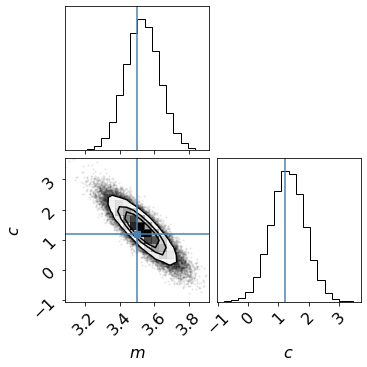

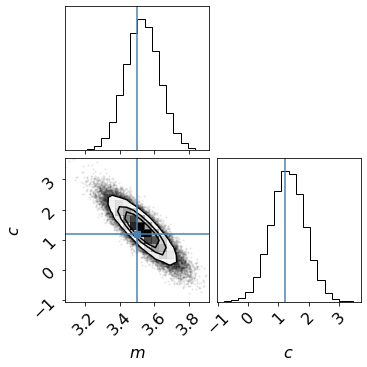

In [10]:
try:
    import corner # import corner.py
except ImportError:
    sys.exit(1)

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

corner.corner(postsamples, labels=[r"$m$", r"$c$"], truths=[m, c])
#fig = corner.corner(postsamples, labels=[r"$m$", r"$c$"], truths=[m, c])
#fig.savefig('PyJAGS.png')

In [11]:
m_samples = postsamples[:,0]
c_samples = postsamples[:,1]

In [12]:
np.mean(m_samples), np.min(m_samples), np.max(m_samples)

(3.5306316211680517, 3.0868286220403838, 3.9171261257356877)

In [13]:
np.mean(c_samples), np.min(c_samples), np.max(c_samples)

(1.318833399266754, -1.0478014695273175, 3.719171777907745)

### plot the posterior distribution along with data points

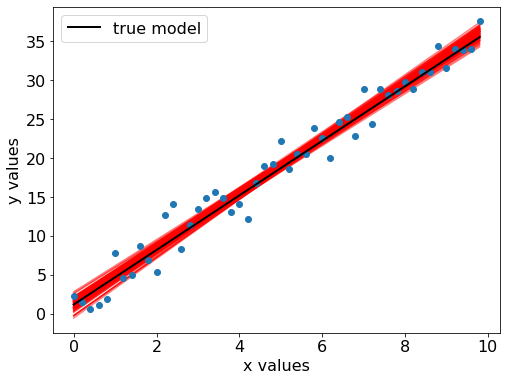

In [14]:
num_sample_model = 100    # (*** change this as needed ***)

plt.figure(figsize = [8, 6])
plt.rcParams['font.size'] = '16'

for i_sample in range(num_sample_model):
    m_posterior, c_posterior = postsamples[i_sample,0], postsamples[i_sample,1]
    y_posterior = straight_line(x, m_posterior, c_posterior)
    
    plt.plot(x, y_posterior, 'r-', alpha=0.5)

plt.plot(x, data, 'o')
plt.plot(x, y_true_model, 'k-', lw=2, label='true model')

plt.xlabel('x values')
plt.ylabel('y values')
plt.legend(loc='best')

plt.show()